In [1]:
from sklearn.datasets import load_wine
import numpy as np
import pandas as pd
samples,labels = load_wine(return_X_y=True)

# Standardization of Data

### 1. Center the wine dataset so that each attribute has zero (empirical) mean.

In [2]:
meanArr=samples.mean(axis=0)
centerSamples= samples-meanArr

### 2. Compute two-dimensional PCA features of the centered wine dataset.

In [20]:
#do PCA of centerSamples
U,S,V=np.linalg.svd(centerSamples)
pca_CS=centerSamples@V.T[:,0:2]
pca_label_0=pca_CS[labels==0]
pca_label_1=pca_CS[labels==1]
pca_label_2=pca_CS[labels==2]

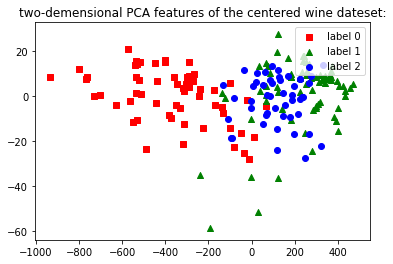

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(pca_label_0[:,0],pca_label_0[:,1],c="r",marker="s",label="label 0")
plt.scatter(pca_label_1[:,0],pca_label_1[:,1],c="g",marker="^",label="label 1")
plt.scatter(pca_label_2[:,0],pca_label_2[:,1],c="b",marker="o",label="label 2")
plt.title("two-demensional PCA features of the centered wine dateset:")
plt.legend(loc=1)
plt.show()

### 3. Normalize the centered wine dataset so that each attribute also has unit (empirical) variance.

In [5]:
#do standardize
stdArr=samples.std(axis=0)
normSamples=centerSamples/stdArr

In [6]:
#do PCA of standardizedSample
U,S,V=np.linalg.svd(normSamples.T)
pca_NS=normSamples@U[:,:2]
pca_label_0=pca_NS[labels==0]
pca_label_1=pca_NS[labels==1]
pca_label_2=pca_NS[labels==2]

### 4. Compute two-dimensional PCA features of the standardized (centered and normalized) wine dataset.

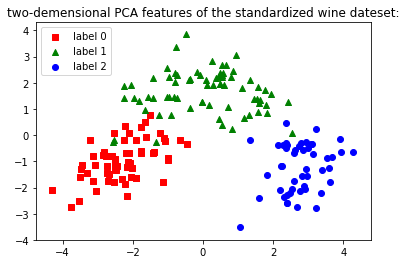

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(pca_label_0[:,0],pca_label_0[:,1],c="r",marker="s",label="label 0")
plt.scatter(pca_label_1[:,0],pca_label_1[:,1],c="g",marker="^",label="label 1")
plt.scatter(pca_label_2[:,0],pca_label_2[:,1],c="b",marker="o",label="label 2")
plt.title("two-demensional PCA features of the standardized wine dateset:")
plt.legend(loc=2)
plt.show()

###  5. In your opinion, based on the above two plots, which PCA features would lead to better classification performance?

In my opinion, the second plot is better, because the center of three different labels are much farer than the first plot, and the boundry is much more clearly.

## Navie Bayes Classification

### 1. Build a three-class naive Bayes classifier

In [8]:
class myNaiveClassifier():
    def __init__(self,norm=True):
        self.meanArr={}
        self.stdArr={}
        self.isNorm=norm
        self.mean_vec=None
        self.std_vec=None
        self.prior_prob={}
        self.pca_transfer=None
        self.features=None
        
    def _pca_data(self,data):
        self.mean_vec=data.mean(axis=1)
        self.std_vec=data.std(axis=1)
        mean_mat = np.tile(self.mean_vec.reshape(data.shape[0],1),[1,data.shape[1]])
        std_mat = np.tile(self.std_vec.reshape(data.shape[0],1),[1,data.shape[1]])
        
        if(self.isNorm):
            norm_data=(data-mean_mat)/std_mat
        else:
            norm_data=data-mean_mat
        U,S,V=np.linalg.svd(norm_data)
        self.features=U[:,0:2].T@norm_data
        self.pca_transfer=U[:,0:2].T
    
    def _process_features(self,labels):
        self.meanArr[0]=self.features.T[labels==0].mean(axis=0)
        self.meanArr[1]=self.features.T[labels==1].mean(axis=0)
        self.meanArr[2]=self.features.T[labels==2].mean(axis=0)

        self.stdArr[0]=self.features.T[labels==0].std(axis=0)
        self.stdArr[1]=self.features.T[labels==1].std(axis=0)
        self.stdArr[2]=self.features.T[labels==2].std(axis=0)
        
        self.prior_prob[0]=sum(np.equal(labels,0))/sum(labels)
        self.prior_prob[1]=sum(np.equal(labels,1))/sum(labels)
        self.prior_prob[2]=sum(np.equal(labels,2))/sum(labels)
        
    def _single_prob(self,mu,sigma,x):
        return (1.0/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2)))
    
    def _predict_single_sample(self,X):
        res=[]
        #print(X)
        for index in range(3):
            current_class_prior=self.prior_prob[index]
            conditional_prob_feature1=self._single_prob(self.meanArr[index][0],self.stdArr[index][0],X[0])
            conditional_prob_feature2=self._single_prob(self.meanArr[index][1],self.stdArr[index][1],X[1])
            posterior_prob=current_class_prior*conditional_prob_feature1*conditional_prob_feature2
            res.append(posterior_prob)
            
        return np.array(res).argsort()[2]

    def getTrainFeatures(self):
        return self.features
    
    def getTestFeatures(self,X):
        mean_mat = np.tile(self.mean_vec.reshape(X.shape[0],1),[1,X.shape[1]])
        std_mat = np.tile(self.std_vec.reshape(X.shape[0],1),[1,X.shape[1]])
        if(self.isNorm):
            norm_X= (X-mean_mat)/std_mat
        else:
            norm_X=X-mean_mat
        X_features=self.pca_transfer@norm_X
        return X_features
    
    def fit(self,data,labels):
        self._pca_data(data)
        self._process_features(labels)
        return self
    
    def predict(self,X):
        mean_mat = np.tile(self.mean_vec.reshape(X.shape[0],1),[1,X.shape[1]])
        std_mat = np.tile(self.std_vec.reshape(X.shape[0],1),[1,X.shape[1]])
        if(self.isNorm):
            norm_X= (X-mean_mat)/std_mat
        else:
            norm_X=X-mean_mat
        X_features=self.pca_transfer@norm_X

        labels=[]
        for i in range(X.shape[1]):
            label=self._predict_single_sample(X_features[:,i])
            labels.append(label)
        return labels

In [9]:
a=myNaiveClassifier(norm=False)
a.fit(samples.T,labels)
output=a.predict(samples.T)

### 2. Use Gaussian naive classifier and K-fold cross validation

In [10]:
import random
indexs=list(range(178))
random.shuffle(indexs)

In [11]:
fold1_data=samples[indexs[:36]]
fold1_labels=labels[indexs[:36]]
fold2_data=samples[indexs[36:72]]
fold2_labels=labels[indexs[36:72]]
fold3_data=samples[indexs[72:108]]
fold3_labels=labels[indexs[72:108]]
fold4_data=samples[indexs[108:144]]
fold4_labels=labels[indexs[108:144]]
fold5_data=samples[indexs[144:178]]
fold5_labels=labels[indexs[144:178]]

In [12]:
folds_data=[fold1_data,fold2_data,fold3_data,fold4_data,fold5_data]
folds_labels=[fold1_labels,fold2_labels,fold3_labels,fold4_labels,fold5_labels]
indexs_arr=np.array([indexs[:36],indexs[36:72],indexs[72:108],indexs[108:144],indexs[144:178]])

#### Case I: centered data only

In [13]:
fold_number=np.array([0,1,2,3,4])
case1_accuracy=[]
print ("Case I")
for i in range(5):
    test_data=folds_data[i]
    test_labels=folds_labels[i]
    train_number=np.delete(fold_number,i,axis=0)
    train_data=np.concatenate((folds_data[train_number[0]],folds_data[train_number[1]],folds_data[train_number[2]],folds_data[train_number[3]]))
    train_labels=np.concatenate((folds_labels[train_number[0]],folds_labels[train_number[1]],folds_labels[train_number[2]],folds_labels[train_number[3]]))

    #use my naive bayes
    naiveBayes=myNaiveClassifier(norm=False)
    naiveBayes.fit(train_data.T,train_labels)
    predict_labels=naiveBayes.predict(test_data.T)
    case1_accuracy.append(sum(test_labels==predict_labels)/test_labels.size)
    print("accuracy of fold ",i," : ",sum(test_labels==predict_labels)/test_labels.size)

Case I
accuracy of fold  0  :  0.8055555555555556
accuracy of fold  1  :  0.7777777777777778
accuracy of fold  2  :  0.75
accuracy of fold  3  :  0.6388888888888888
accuracy of fold  4  :  0.7647058823529411


#### Case II: standardized data

In [14]:
fold_number=np.array([0,1,2,3,4])
case2_accuracy=[]
print("Case II")
for i in range(5):
    test_data=folds_data[i]
    test_labels=folds_labels[i]
    train_number=np.delete(fold_number,i,axis=0)
    train_data=np.concatenate((folds_data[train_number[0]],folds_data[train_number[1]],folds_data[train_number[2]],folds_data[train_number[3]]))
    train_labels=np.concatenate((folds_labels[train_number[0]],folds_labels[train_number[1]],folds_labels[train_number[2]],folds_labels[train_number[3]]))

    #use my naive bayes
    naiveBayes=myNaiveClassifier(norm=True)
    naiveBayes.fit(train_data.T,train_labels)
    predict_labels=naiveBayes.predict(test_data.T)
    case2_accuracy.append(sum(test_labels==predict_labels)/test_labels.size)
    print("accuracy of fold ",i," : ",sum(test_labels==predict_labels)/test_labels.size)

Case II
accuracy of fold  0  :  0.9722222222222222
accuracy of fold  1  :  0.9722222222222222
accuracy of fold  2  :  0.9722222222222222
accuracy of fold  3  :  0.9444444444444444
accuracy of fold  4  :  0.9411764705882353


#### Case III: use sklearn.naive_bayes.GaussinaNB

In [15]:
from sklearn.naive_bayes import GaussianNB

In [16]:
fold_number=np.array([0,1,2,3,4])
case3_accuracy=[]
print("Case III")
for i in range(5):
    test_data=folds_data[i]
    test_labels=folds_labels[i]
    train_number=np.delete(fold_number,i,axis=0)
    train_data=np.concatenate((folds_data[train_number[0]],folds_data[train_number[1]],folds_data[train_number[2]],folds_data[train_number[3]]))
    train_labels=np.concatenate((folds_labels[train_number[0]],folds_labels[train_number[1]],folds_labels[train_number[2]],folds_labels[train_number[3]]))

    #use my naive bayes to do PCA
    naiveBayes=myNaiveClassifier(norm=True)
    naiveBayes.fit(train_data.T,train_labels)
    train_features=naiveBayes.getTrainFeatures()
    test_features=naiveBayes.getTestFeatures(test_data.T)
    
    #usk sklearn
    gnb=GaussianNB()
    gnb.fit(train_features.T,train_labels)
    predict_labels=gnb.predict(test_features.T)
    case3_accuracy.append(sum(test_labels==predict_labels)/test_labels.size)
    print("accuracy of fold ",i," : ",sum(test_labels==predict_labels)/test_labels.size)

Case III
accuracy of fold  0  :  0.9722222222222222
accuracy of fold  1  :  0.9722222222222222
accuracy of fold  2  :  0.9722222222222222
accuracy of fold  3  :  0.9444444444444444
accuracy of fold  4  :  0.9411764705882353


### 3. compare and contrast the three cases

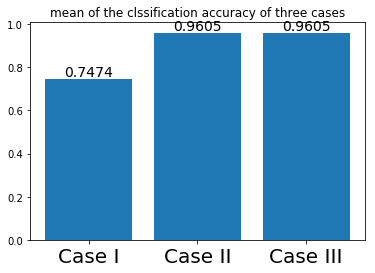

In [17]:
means=np.array([np.mean(case1_accuracy),np.mean(case2_accuracy),np.mean(case3_accuracy)])
varss=np.array([np.var(case1_accuracy),np.var(case2_accuracy),np.var(case3_accuracy)])
bar_labels=['Case I','Case II','Case III']
X_pos=list(range(3))
plt.bar(X_pos,means)
plt.xticks(X_pos,bar_labels,size=20)
plt.title("mean of the clssification accuracy of three cases")
for a,b in zip(X_pos,means):
    plt.text(a, b-0.002, '%.4f' % b, ha='center', va= 'bottom',fontsize=14)

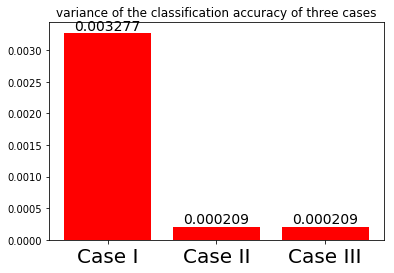

In [18]:
bar_labels=['Case I','Case II','Case III']
X_pos=list(range(3))
plt.bar(X_pos,varss,color='r')
plt.xticks(X_pos,bar_labels,size='20')
plt.title("variance of the classification accuracy of three cases")
for a,b in zip(X_pos,varss):
    plt.text(a, b, '%.6f' % b, ha='center', va= 'bottom',fontsize=14)

So we can see that the case II and casee III have a better solution, their means of accuracy are higher and their variance is smaller. Which means they have higher accuracy stapler outputs.

This solution also shows that it is very important to standardize the data before we apply the algorithms.